In [1]:
import numpy as np
import pandas as pd

import os, ast
    
import library as lib
from library import GlobalVars
import faiss_experiment as faiss_tool

import matplotlib.pyplot as plt


#concatenate the results from multiple rounds in order to agregate the results
lib.concat_csvs([
            GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv', \
            GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv', \
            GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv',\
            GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv',\
            GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv'], GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_kfold_all.csv')


,segment_lenght,segment_overlap,feature,vector_operation,metric_type,vote_type,neighbors,index_params
0,0.965010,159306,40236,1.067880,0.740044,25.683925,600.125000,74b480f3d00c287b40f42a4a250fbbee
1,0.965101,159306,40236,2.101814,0.878717,25.683925,621.203125,f1319b7108b5619740ddb4c3f09c6eca
2,0.965184,159306,40236,1.437940,1.439593,25.683925,717.328125,7cca7af2b574f3eb39b6e06958a1ebc1
3,0.965338,159306,40236,3.456696,0.363618,25.844142,631.671875,5fbff315501a515b6f88ec1d54eab0e4
4,0.965184,159306,40236,2.869022,1.559074,25.844142,754.656250,0e07cf82378ca593d6b0ad2311566c5d
...,...,...,...,...,...,...,...,...
1195,0.952832,159306,40236,9.885271,1.603286,3.094337,1290.921875,0961d520ba2c4916484a87a1e241d4df
1196,0.958156,159306,40236,13.917870,0.372289,3.414772,650.656250,00a28ae1e4dd40abba66e29e07f5a078
1197,0.956917,159306,40236,7.144529,0.594015,3.414772,895.718750,d5a28e9d6ce71a1209285359e348a51c
1198,0.956926,159306,40236,7.175434,0.983813,3.414772,1259.796875,b626d750d65da4434b25cfc468c26503


Error generating milvus fields: 'str' object has no attribute 'get'
  indexFactory_full2 accuracy_min accuracy_mean accuracy_max train_used_memory_min train_time_min predict_time_min
0   IVF1000,SQ8-None       93.25%        93.54%       93.77%                  7.45         1.1374           0.6594
1   IVF4000,SQ8-None       93.42%        93.51%       93.66%                  7.93         4.3105           1.1353
2  IVF2000,Flat-None       93.40%        93.50%       93.64%                 25.84         1.8936           0.4613
3  IVF4000,Flat-None       93.41%        93.50%       93.64%                 26.16         3.4614           0.4813
4  IVF1000,Flat-None       93.31%        93.47%       93.64%                 25.68         1.0190           0.3569
5   IVF2000,SQ8-None       93.35%        93.51%       93.61%                  7.61         2.2864           0.6570
6  IVF4000,PQ10-None       88.27%        91.22%       93.16%                  3.41         7.0562           0.3911
7  IVF2000,P

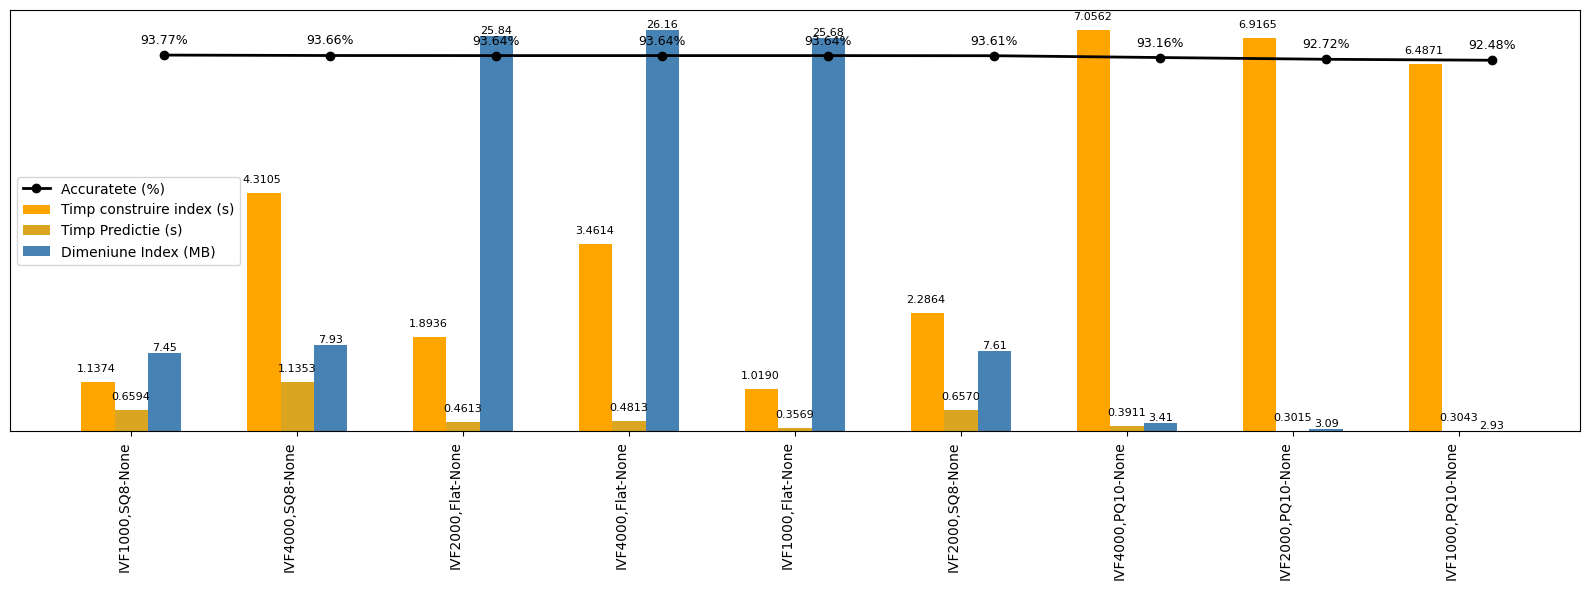

In [5]:
def scale_values(df):
    # Grupuri logice
    time_cols = ['train_time_min', 'predict_time_min']
    memory_cols = ['train_used_memory_min']

    # 1. Concatenăm valorile din cele 2 coloane de timp și normalizăm împreună
    all_time_values = pd.concat([df[col] for col in time_cols])
    min_time = all_time_values.min()
    max_time = all_time_values.max()

    # Normalizare pe ambele coloane de timp
    for col in time_cols:
        df[f"{col}_scaled"] = (df[col] - min_time) / (max_time - min_time)

    # 2. La fel pentru memorie
    all_memory_values = pd.concat([df[col] for col in memory_cols])
    min_mem = all_memory_values.min()
    max_mem = all_memory_values.max()

    for col in memory_cols:
        df[f"{col}_scaled"] = (df[col] - min_mem) / (max_mem - min_mem)
    
    return df
    
def format_time_on_plot(time_value):
    return f"{time_value:.4f}"

def format_size_on_plot(size_value):
    return (f"{size_value:.2f}")

def represent_index_performances_v3(df, group_field, image_name, use_index_memory = True, use_train_time = True, angle_label=90):
    accuracy_field = "accuracy_max"
    x = range(len(df))
    x_labels = df[group_field] #.apply(lambda item: ast.literal_eval(item)["params"])
    bar_width = 0.2

    df = scale_values(df)
    fig, ax = plt.subplots(figsize=(16, 6))

    if (use_train_time):
        ax.bar([p - bar_width for p in x], df['train_time_min_scaled'], width=bar_width, label='Timp construire index (s)', color='orange')
    ax.bar(x, df['predict_time_min_scaled'], width=bar_width, label='Timp Predictie (s)', color='goldenrod')


    # Bare pentru memorie (2)
    if (use_index_memory):
        ax.bar([p + bar_width for p in x], df['train_used_memory_min_scaled'], width=bar_width, label='Dimeniune Index (MB)', color='steelblue')

    # Linie pentru accuracy
    ax.plot([p + bar_width for p in x], df[accuracy_field], color='black', marker='o', linewidth=2, label='Accuratete (%)')

    # Afișare valori reale pe linia de accuracy
    for i, row in df.iterrows():
        text_pos_y = row[accuracy_field] + 0.02
        ax.text(i + bar_width, text_pos_y, f"{100 * row[accuracy_field]:.2f}%", ha='center', va='bottom', fontsize=9, color='black')
        
    for i, row in df.iterrows():
        if (use_train_time):
            ax.text(i - bar_width - 0.01, row['train_time_min_scaled'] + 0.02, format_time_on_plot(row['train_time_min']), ha='center', va='bottom', fontsize=8)        
        ax.text(i, row['predict_time_min_scaled'] + 0.02, format_time_on_plot(row['predict_time_min']), ha='center', va='bottom', fontsize=8)
        if (use_index_memory):
            ax.text(i + bar_width, row['train_used_memory_min_scaled'], format_size_on_plot(row['train_used_memory_min']), ha='center', va='bottom', fontsize=8)
        
    ax.set_yticks([]) 
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=angle_label, ha='right')
    plt.grid(False)
    #plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.2, color='gray')
    #plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.2, color='gray')
    ax.legend()
    plt.tight_layout()
    plt.savefig(image_name, format="svg")
    plt.show()

def extract_all_faiss_results(results_file_path, group_field = 'indexFactory', sort_by = 'accuracy_max', sort_ascending=False):
    df = pd.read_csv(results_file_path)
    
    #df = df[df['index_params'].str.contains('PQ')]
    agg_columns = ['accuracy', 'train_time', 'predict_time', 'train_used_memory', 'predict_used_memory']

    try:
        df['indexTypeMilvus'] = df['index_params'].apply(lambda item: ast.literal_eval(item).get("index_type"))
        df['nListmilvus'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("params").get("nlist")))
        df['pq_m_milvus'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("params").get("m", "")))
        df['nprobeMilvus'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("nprobe")))
        df['indexFactoryMilvus'] = 'IVF' + df['nListmilvus'] + df['indexTypeMilvus'].str.replace('IVF_FLAT', ',Flat')
        df['indexFactoryMilvus'] = df['indexFactoryMilvus'].str.replace('IVF_SQ8', ',SQ8') 
        
        df['indexFactoryMilvus'] = np.where(df['indexTypeMilvus']=='IVF_PQ', 'IVF' + df['nListmilvus'] + ",PQ" + df['pq_m_milvus'].astype(str), df['indexFactoryMilvus'])        
        df['indexFactoryMilvus2'] = df['indexTypeMilvus'] + "-" + df['nListmilvus'] + "-" + df['nprobeMilvus'] 
        df = df[df['pq_m_milvus'] != '8'] #exclude PQ8 
    except Exception as e:
        print("Error generating milvus fields:", e)
        pass
    df['indexFactory'] = df['index_params'].apply(lambda item: ast.literal_eval(item).get("params"))
    df['nprobe'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("nprobe")))
    df['efConstruction'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("efConstruction")))
    df['efSearch'] = df['index_params'].apply(lambda item: str(ast.literal_eval(item).get("efSearch")))
    try:
        df['indexFactory_full1'] = df['indexFactory'] + "-" + df['nprobe']
        df['indexFactory_full2'] = df['indexFactory'] + "-" + df['efConstruction']
        df['indexFactory_full3'] = df['indexFactory'] + "-" + df['efConstruction'] + "-" + df['efSearch']
    except:
        print("Error generating other index fields:", e)
        pass
        
    #df = df[df['index_params'].str.contains(',PQ')]
    #print(df.head(100).to_string())
    result = df.groupby(group_field)[agg_columns].agg(['min', 'mean', 'max'])
    result.columns = ['_'.join(col).strip() for col in result.columns.values]
    result = result.reset_index()

    # Sorting based on accuracy descending
    result = result.sort_values(by=sort_by, ascending=sort_ascending)
    result = result.reset_index(drop=True)
    df_reduced = result[[group_field, 'accuracy_min', 'accuracy_mean', 'accuracy_max', 'train_used_memory_min', 'train_time_min', 'predict_time_min']].copy()
    
    df_formated = df_reduced.copy()
    for col in ['accuracy_min', 'accuracy_mean', 'accuracy_max']:
        df_formated[col] = df_formated[col] *100
        df_formated[col] = df_formated[col].apply(lambda x: f"{x:.2f}%")
    df_formated["train_used_memory_min"] = df_formated["train_used_memory_min"].map(lambda x: f"{x:.2f}")
    df_formated["train_time_min"] = df_formated["train_time_min"].map(lambda x: f"{x:.4f}")
    df_formated["predict_time_min"] = df_formated["predict_time_min"].map(lambda x: f"{x:.4f}")
    print(df_formated.to_string(index=True))
    return df_reduced

results_file_path = GlobalVars.experiments_path + 'executed_faiss_experiments_index_ivf_all_round0_kfold.csv'
group_field = 'indexFactory_full2'
df = extract_all_faiss_results(results_file_path, group_field)
represent_index_performances_v3(df, group_field,  "index_hnsw_results_bigdataset.svg", angle_label = 90)

In [ ]:
results_file_path='experiments' + os.sep + '20250620_executed_knn_configs_results_v3_all.csv'
df_sorted = lib.load_resuls_file(results_file_path)
top1_n = 50
top2_n = 100
df_top1, df_top2 = lib.print_results_stat(df_sorted, top1_n, top2_n)


df_cosine = df_sorted[df_sorted['metric_type'] == 'cosine']
df_correlation = df_sorted[df_sorted['metric_type'] == 'correlation']
print('Cosine avg train time (s):', df_cosine['train_time'].mean(), "Train memory:", df_cosine['train_used_memory'].mean(),  "Predict time (S)", df_cosine['predict_time'].mean(), "Predict memory (MB):", df_cosine['predict_used_memory'].mean())
print('correlation avg train time (s):', df_correlation['train_time'].mean(), "Train memory:", df_correlation['train_used_memory'].mean(), "Predict time (S)", df_correlation['predict_time'].mean(), "Predict memory (MB):", df_correlation['predict_used_memory'].mean())


lucky_winner = {}
# lucky_winner['segment_lenght'] = lib.display_one_param_pie("segment_lenght", df_sorted, df_top100, df_top200, 200, 100, "Segment lenght")
# #lucky_winner['segment_overlap'] = lib.display_one_param_pie("segment_overlap", df_sorted, df_top100, df_top200, 200, 100, "Segment Overlap")
# lib.display_2params_pie("segment_lenght", "segment_overlap", df_sorted, df_top100, df_top200, 200, 100, "Segment lenght and Overlap")
# lucky_winner['feature'] = lib.display_one_param_pie("feature", df_sorted, df_top100, df_top200, 200, 100, "Applied feature")
lucky_winner['vector_operation'] = lib.display_one_param_pie("vector_operation", df_sorted, df_top1, df_top2, top1_n, top2_n, "Feature Agregation")
#lib.display_2params_pie("feature", "vector_operation", df_sorted, df_top100, df_top200, 200, 100, "Feature and agregation")
lucky_winner['metric_type'] = lib.display_one_param_pie("metric_type", df_sorted, df_top1, df_top2, top1_n, top2_n, "Metric Type")
lucky_winner['vote_type'] = lib.display_one_param_pie("vote_type", df_sorted, df_top1, df_top2, top1_n, top2_n, "Vote Type")
lucky_winner['neighbors'] = lib.display_one_param_pie("neighbors", df_sorted, df_top1, df_top2, top1_n, top2_n, "Index Param")

faiss_tool.report_results(results_file_path, 20)

#results_file_path='experiments' + os.sep + 'knn_comparations.csv'
